# Fitting Cosmology

#### Introduction
From the previous notebooks we should have a handle on how to run CAMB to generate some observables, and also how to fit some data using the Metropolis-Hastings algorithm. In this workbook, we'll put all of these things together to fit some cosmological data. We'll also use a neat numerical interpolation trick to speed up the fitting.

#### Understanding the data
First, let's make sure we understand the data we have been given. The following code should read in some Planck TT, EE, TE CMB power spectra with some error bars, a set of BAO measurements, and some galaxy power spectra from the WiggleZ survey. It will then plot the measurements. Make sure you understand what each set of data is showing.

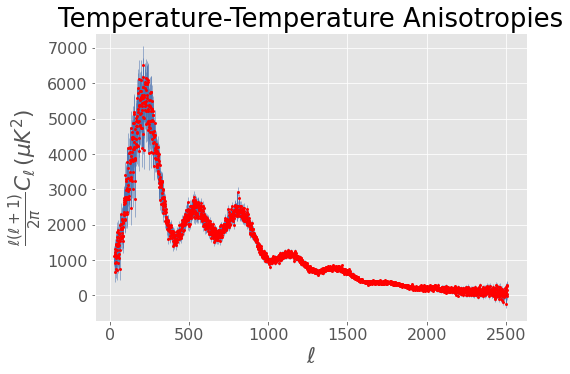

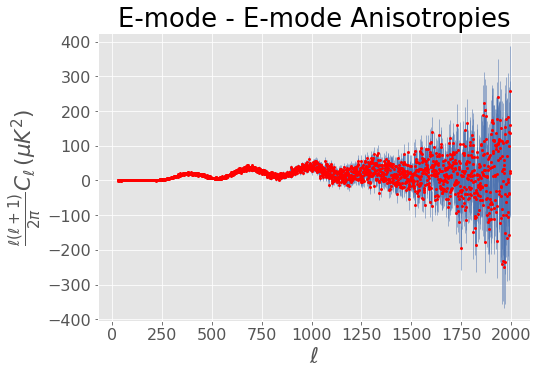

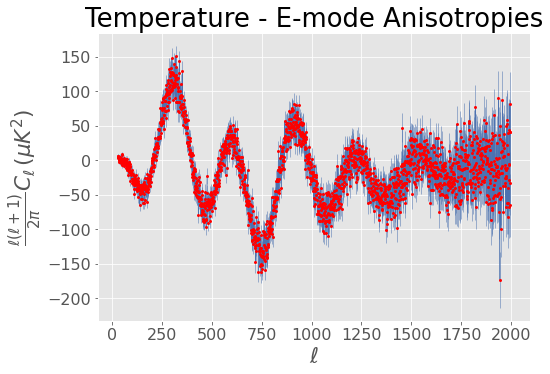

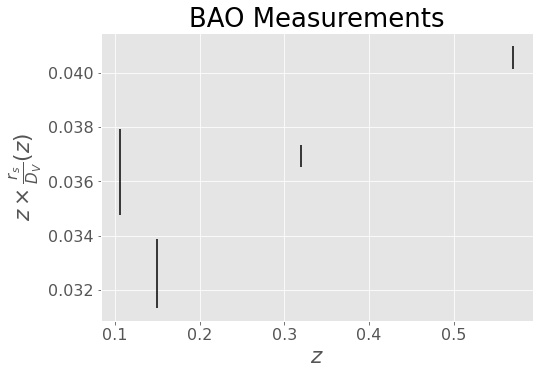

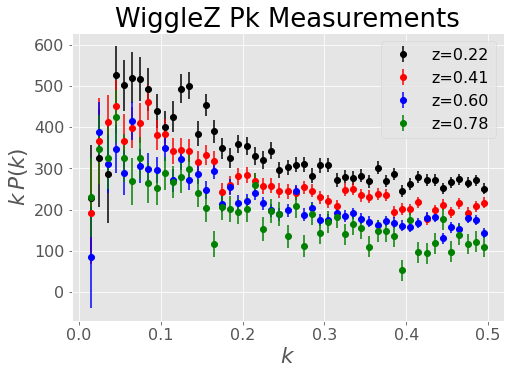

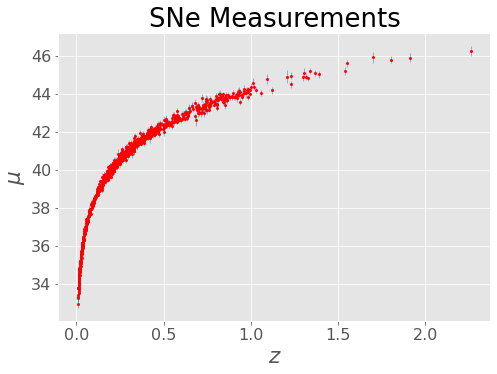

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
font = {'size': 18}
plt.rc('font', **font)

# CMB data
TT_ell, TT_power, TT_err = np.loadtxt("data/Planck_TT.dat", unpack=True)
TE_ell, TE_power, TE_err = np.loadtxt("data/Planck_TE.dat", unpack=True)
EE_ell, EE_power, EE_err = np.loadtxt("data/Planck_EE.dat", unpack=True)
TT_ell = TT_ell.astype(int)    # Make these into integers so we can use these as indexes
TE_ell = TE_ell.astype(int)   
EE_ell = EE_ell.astype(int)

# BAO data. The first value is the redshift, then measurement then error. All of these are measurements of
# a quantities called r_s/D_v, the ratio of the sounds horizon at the baryon drag epoch to the volume-averaged
# distance to the redshift. CAMB calculates this for us as part of its standard distance calculations
Beutler2012 = np.array([0.106, 0.3427729554968161, 0.015])
Ross2015 = np.array([0.15, 0.2173470199112723, 0.0084])
DR12LOWZ = np.array([0.32, 0.1154382989526693, 0.0013])
DR12CMASS = np.array([0.57, 0.07116576972586867, 0.00075])
BAOredshifts = np.array([Beutler2012[0],Ross2015[0],DR12LOWZ[0],DR12CMASS[0]])
BAOmeasurements = np.array([Beutler2012[1],Ross2015[1],DR12LOWZ[1],DR12CMASS[1]])
BAOerrors = np.array([Beutler2012[2],Ross2015[2],DR12LOWZ[2],DR12CMASS[2]])

# Power spectrum data
WiggleZ_reds = np.array([0.22, 0.41, 0.60, 0.78])  # The redshifts of our measurements
WiggleZ_z0p22_k, WiggleZ_z0p22_pk, WiggleZ_z0p22_err = np.loadtxt("data/WiggleZ_z0p22.dat", unpack=True)
WiggleZ_z0p41_k, WiggleZ_z0p41_pk, WiggleZ_z0p41_err = np.loadtxt("data/WiggleZ_z0p41.dat", unpack=True)
WiggleZ_z0p60_k, WiggleZ_z0p60_pk, WiggleZ_z0p60_err = np.loadtxt("data/WiggleZ_z0p60.dat", unpack=True)
WiggleZ_z0p78_k, WiggleZ_z0p78_pk, WiggleZ_z0p78_err = np.loadtxt("data/WiggleZ_z0p78.dat", unpack=True)

# Supernova data. These are in the form of 'distance moduli', mu = 5*log(dL) + 25 
# where dL is the luminosity distance.
Pantheon_z, Pantheon_mu, Pantheon_mu_err = np.loadtxt("data/Pantheon.dat", unpack=True)

# Now make some plots of these
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(TT_ell, TT_power, yerr=TT_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5)
ax.set_title('Temperature-Temperature Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(EE_ell, EE_power, yerr=EE_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5)
ax.set_title('E-mode - E-mode Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(TE_ell, TE_power, yerr=TE_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5)
ax.set_title('Temperature - E-mode Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(BAOredshifts, BAOredshifts*BAOmeasurements, yerr=BAOredshifts*BAOerrors, color='k', linestyle="None")
ax.set_title('BAO Measurements')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$z\times \frac{r_{s}}{D_{V}}(z)$')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(WiggleZ_z0p22_k, WiggleZ_z0p22_k*WiggleZ_z0p22_pk, yerr=WiggleZ_z0p22_k*WiggleZ_z0p22_err, color='k', marker='o', linestyle='None', label='z=0.22')
ax.errorbar(WiggleZ_z0p41_k, WiggleZ_z0p41_k*WiggleZ_z0p41_pk, yerr=WiggleZ_z0p41_k*WiggleZ_z0p41_err, color='r', marker='o', linestyle='None', label='z=0.41')
ax.errorbar(WiggleZ_z0p60_k, WiggleZ_z0p60_k*WiggleZ_z0p60_pk, yerr=WiggleZ_z0p60_k*WiggleZ_z0p60_err, color='b', marker='o', linestyle='None', label='z=0.60')
ax.errorbar(WiggleZ_z0p78_k, WiggleZ_z0p78_k*WiggleZ_z0p78_pk, yerr=WiggleZ_z0p78_k*WiggleZ_z0p78_err, color='g', marker='o', linestyle='None', label='z=0.78')
ax.set_title('WiggleZ Pk Measurements')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$k\,P(k)$')
plt.legend(loc='upper right', fontsize=16)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(Pantheon_z, Pantheon_mu, yerr=Pantheon_mu_err, ls='None', marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5)
ax.set_title('SNe Measurements')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')
plt.show()

#### Build an interpolator
Okay, so we have our data, which means we also know what observables we might want to fit against. In this part of the notebook, let's generate some interpolators for all of our observables.

We want our interpolator to take as input our two cosmological parameters and return the 3 CMB power spectra, the BAO quantities at the input redshifts and the matter power spectrum at the measured $k$ values and redshifts. We'll store these for each cosmology in the same way we did in the first notebook `CAMB_Introduction.ipynb`, with each observable as an individual element. I've coded this up for you below, but you'll need to modify it based on your parameters of choice. Try to understand the format of the array of observables as we'll need to access this when we want to interpolate.

In [ ]:
import numpy as np
import camb
import matplotlib.pyplot as plt

# Firstly, take our trusty CAMB function from the first notebook and make it return a list of all the observables
# we want; the TT, TE and EE power spectra, the values of r_s/D_v at our four redshifts, and the 4 matter power spectra
def run_camb(Omega_bh2=0.02242, Omega_cdmh2=0.11933, Omega_k=0.0, H0=67.66, DE_EoS=-1.0, 
             scalar_amplitude = 2.105e-9, max_pk_redshift=10.0):
    
    # Set the cosmological parameters
    my_cosmology = camb.set_params(ombh2 = Omega_bh2, omch2 = Omega_cdmh2, omk = Omega_k, H0=H0, 
                                   w=DE_EoS, As=scalar_amplitude, WantCls=True, 
                                   WantTransfer=True, WantDerivedParameters=True, lmax=2500,
                                   redshifts=np.concatenate([np.logspace(np.log10(max_pk_redshift), -2.0, 10),[0.0]]))
    
    # Run CAMB
    run = camb.get_results(my_cosmology)
    
    # Get the CMB Power spectra
    TT, EE, BB, TE = np.split(run.get_cmb_power_spectra(spectra=['total'], CMB_unit='muK')['total'],4,axis=1)
    
    # CAMB also has a convenient function to return the parameters of interest for BAO surveys given some
    # redshifts. Pass this function the four redshifts of our measurements, and the array it returns contains
    # the value of r_s/D_v at those redshifts for the current cosmological model
    BAOparams = run.get_BAO(BAOredshifts, my_cosmology)[0:,0]
    
    # Generate a Pk interpolator and use this to get the power spectrum for the WiggleZ redshifts and k-values
    Pk_interpolator = run.get_matter_power_interpolator()
    Pk_z0p22 = Pk_interpolator.P(WiggleZ_reds[0], WiggleZ_z0p22_k)
    Pk_z0p41 = Pk_interpolator.P(WiggleZ_reds[1], WiggleZ_z0p41_k)
    Pk_z0p60 = Pk_interpolator.P(WiggleZ_reds[2], WiggleZ_z0p60_k)
    Pk_z0p78 = Pk_interpolator.P(WiggleZ_reds[3], WiggleZ_z0p78_k)
    
    # Generate a set of distance moduli at all our SNe redshifts
    DistMod = 5.0*np.log10(run.luminosity_distance(Pantheon_z)) + 25.0
    
    return [TT, TE, EE, BAOparams, Pk_z0p22, Pk_z0p41, Pk_z0p60, Pk_z0p78, DistMod]

# Now generate a list of cosmological parameter values for input. These will form our x and y arrays.
# I'd recommend 10x10 values for your cosmological parameters, as even then it will take a few minutes to run.
Omega_b_min, Omega_b_max, nOmega_b = 0.04, 0.06, 10
w_min, w_max, nw = -0.95, -1.05, 10
Omega_b_vals = np.linspace(Omega_b_min, Omega_b_max, nOmega_b)
w_vals = np.linspace(w_min, w_max, nw)

# Now loop over our cosmological parameter combinations and save the results in a list
results = []
for i, Omega_b in enumerate(Omega_b_vals):
    for j, w in enumerate(w_vals):
        results.append(run_camb(Omega_bh2=Omega_b*0.6766**2, DE_EoS=w))
        print(i,j)
        
# If we want to access the different observables for a given cosmology, we can then do so using the following syntax
# For Omega_b=Omega_b_min, w=H0_min (element 0)
TT_model, TE_model, EE_model = results[0][0], results[0][1], results[0][2]
Beutler2012_model, ROSS2015_model, DR12LOWZ_model, DR12CMASS_model = results[0][3]
Pk_z0p22_model, Pk_z0p41_model, Pk_z0p60_model, Pk_z0p78_model = results[0][4], results[0][5], results[0][6], results[0][7]
DistMod_model = results[0][8]
print(str("Omega_b=%6.4lf, w=%6.4lf:" % (Omega_b_vals[0], w_vals[0]))) 
print(TT_model)

# For Omega_cdmh2=Omega_cdmh2_max, H0=H0_max (element 99)
TT_model, TE_model, EE_model = results[99][0], results[99][1], results[99][2]
Beutler2012_model, ROSS2015_model, DR12LOWZ_model, DR12CMASS_model = results[99][3]
Pk_z0p22_model, Pk_z0p41_model, Pk_z0p60_model, Pk_z0p78_model = results[99][4], results[99][5], results[99][6], results[99][7]
DistMod_model = results[99][8]
print(str("Omega_b=%6.4lf, w=%6.4lf:" % (Omega_b_vals[9], w_vals[9]))) 
print(TT_model)

Do you understand how the above code works? Are you able to modify it for the cosmological parameters you are interested in? How would you interpolate this huge array to get the observables for any combination of your two parameters? This is what we will tackle in the next section.

#### 2D Linear interpolation
If we have some evaluations of a function z(x,y) we can interpolate in both x and y to return z without needing to evaluate this every time. This is exactly what we want for our model fitting purposes. We want to interpolate our observables (z), as a function of our two cosmological parameters.

The formula for Bilinear interpolation is quite a bit more complicated than the 1D version, but the principle is the same and the algorithm quite similar
1. Compute and store $z_{ij}(x_{i},y_{j})$ for a suitably large range of $x_{i}$ and $y_{j}$. We already did this above.
2. For every value $z(x,y)$ we want to interpolate:
    1. Find the values of $x_{0}$ and $x_{1}$ in our list of $x_{i}$ that bound $x$, such that $x_{1}>x$ and $x_{0} < x$.
    2. Find the values of $y_{0}$ and $y_{1}$ in our list of $y_{i}$ that bound $y$, such that $y_{1}>y$ and $y_{0} < y$.
    2. Retrieve the corresponding $z_{00}, z_{01}, z_{10}$ and $z_{11}$
    3. Use all of these values to compute $z(x,y)$.
    
The formula we'll need is
\begin{equation}
z(x,y) = \biggl(1-\frac{y-y_{0}}{y_{1}-y_{0}}\biggl)\biggl[\biggl(1-\frac{x-x_{0}}{x_{1}-x_{0}}\biggl)z_{00} + \frac{x-x_{0}}{x_{1}-x_{0}}z_{10}\biggl] + \frac{y-y_{0}}{y_{1}-y_{0}}\biggl[\biggl(1-\frac{x-x_{0}}{x_{1}-x_{0}}\biggl)z_{01} + \frac{x-x_{0}}{x_{1}-x_{0}}z_{11}\biggl]
\end{equation}

This may look daunting, but if we look closely, we'll see that this is really just a weighted sum of our computed quantities $z$ at four locations where the weights can be computed in the same way as for 1D interpolation. This has already been coded up below and shouldn't need modifying, but it would be good if you can understand what each of the lines in the function `bilinear_interpolator` does.

#### Fitting the TT power spectrum
Now that we have built our array of observables let's use it to fit our data. We'll use the same Metropolis-Hasting algorithm from the notebook `Model_fitting.ipynb`. An almost completed version of this algorithm is below, however it is missing a few key components: 
1. We need to specify the data we are fitting. To begin with, let's make this the TT power spectrum we read in at the beginning of this notebook.
2. We need to specify the correct parts of the observables that we are treating as our model.
3. We need to update it for our cosmological parameters.
4. We need to update the priors and proposal widths for these parameters.

Have a look at the code below and try modifying it to do these things.

In [ ]:
# This function is our 2D interpolator for all the observables.
def bilinear_interpolator(x, y, xi, yj, zij):
    
    z = []  # This will hold our interpolated observables

    # First find the values of x_{0} and x_{1}
    loi = np.where(xi <= x)[0]
    hii = np.where(xi > x)[0]
    x0 = xi[loi[-1]]
    x1 = xi[hii[0]]

    # Now find the values of y_{0} and y_{1}
    loj = np.where(yj <= y)[0]
    hij = np.where(yj > y)[0]
    y0 = yj[loj[-1]]
    y1 = yj[hij[0]]

    # Now find the corresponding distances at the four points we need
    z00 = zij[loi[-1]*len(xi)+loj[-1]]
    z01 = zij[loi[-1]*len(xi)+hij[0]]
    z10 = zij[hii[0]*len(xi)+loj[-1]]
    z11 = zij[hii[0]*len(xi)+hij[0]]

    # Now interpolate our observables using the 2D formula. We have to do this
    # for each observable separately, but this is easy as the weights don't change
    wx = (x-x0)/(x1-x0)
    wy = (y-y0)/(y1-y0)
    for i in range(len(z00)):
        z.append((1.0 - wy)*((1.0 - wx)*z00[i] + wx*z10[i]) + wy*((1.0 - wx)*z01[i] + wx*z11[i]))

    return z

# This function specifies the priors. You will need to modify these based on your
# cosmological parameters.
def log_prior(parameters):
    
    # Implement some uniform priors for the parameters we are interested in 
    # **Add your code here**
    
    # For uniform priors we can return 0.
    return 0.0

# This function returns the natural logarithm of the likelihood of the data given the model. 
# We assume the data are Gaussian distributed so this is related to the chi_squared value
def log_likelihood(parameters, data_x, data_y, data_err):
        
    # Here we call our interpolator to get the observables for the two cosmological parameters
    observable_model = bilinear_interpolator(parameters[0],parameters[1], Omega_b_vals, w_vals, results)
    TT_model = observable_model[0]
    TE_model = observable_model[1]
    EE_model = observable_model[2]
    BAOparams_model = observable_model[3]
    Pk_z0p22_model = observable_model[4]
    Pk_z0p41_model = observable_model[5]
    Pk_z0p60_model = observable_model[6]
    Pk_z0p78_model = observable_model[7]
    DistMod_model = observable_model[8]
    
    # Here we need to be clear which observables we are modelling and make sure we take
    # the correct ell range for the TT, TE, EE power spectra. So set this here
    # Examples: TT only    - model = np.concatenate([TT_model[data_x[0],0]])
    #           TT+TE+EE   - model = np.concatenate([TT_model[data_x[0],0],TE_model[data_x[1],0],EE_model[data_x[2],0]])
    #           Everything - model = np.concatenate([TT_model[data_x[0],0],TE_model[data_x[1],0],EE_model[data_x[2],0],
    #                                                BAOparams_model,Pk_z0p22_model,Pk_z0p41_model,Pk_z0p60_model,
    #                                                Pk_z0p78_model,DistMod_model])
    # **Add your code here**
    model = np.concatenate([])

    # Now compute the chi_squared between the data and model
    chi_squared = np.sum((data_y - model)**2/data_err**2)
        
    # Return the log-likelihood
    return -0.5*chi_squared

def metropolis_hastings(data_x, data_y, data_err, begin, nsamples, proposal_width):
    
    # Create an array to store the samples
    samples = np.empty((nsamples,len(begin)))
    
    # Evaluate the likelihood for the starting values
    samples[0,0:] = begin
    log_posterior_old = log_prior(samples[0,0:])
    if np.isinf(log_posterior_old):
        print("Starting values are outside your prior range!")
        return
    log_posterior_old += log_likelihood(samples[0,0:], data_x, data_y, data_err)

    # Loop over the required number of iterations
    acceptance = 0
    for i in range(1,nsamples):
        
        # Generate a new set of parameters by drawing from a Gaussian with the proposal width
        Omega_b_new, w_new = np.random.normal(samples[i-1,0:], proposal_width)
        
        # Compute the log-prior and log-likelihood for the new samples 
        # If the new samples our outside our prior, we don't accepy them by default
        log_posterior_new = log_prior([Omega_b_new, w_new])
        if np.isinf(log_posterior_new):
            samples[i,0:] = samples[i-1,0:]
            continue
        log_posterior_new += log_likelihood([Omega_b_new, w_new], data_x, data_y, data_err)
        
        # Compute the acceptance ratio
        alpha = np.exp(log_posterior_new - log_posterior_old)
        
        # Accept or reject the proposed values and store the results in samples
        # Update the value of "acceptance" when we accept a sample so we can see how often we do it
        if alpha >= 1.0:
            samples[i,0:] = Omega_b_new, w_new
            log_posterior_old = log_posterior_new
            acceptance += 1
        else:
            if np.random.uniform() < alpha:
                samples[i,0:] = Omega_b_new, w_new
                log_posterior_old = log_posterior_new
                acceptance += 1
            else:
                samples[i,0:] = samples[i-1,0:]
                
        # Let's print how often we are accepting samples every thousand interations. 
        # This tells us whether we have set reasonable values for the proposal distribution
        if i%10000 == 0:
            print(str("Number of iterations=%d, Acceptance percentage:%d" % (i, int(100.0*acceptance/i))))
        
    # Return the samples for analysis
    return samples

# Set up a vector of the observables we want to fit. Try and make this generic so we can fit multiple
# observables simultaneously. 
# Examples: TT only    - data_x = [TT_ell], data_y = np.concatenate([TT_power]), data_err = np.concatenate([TT_err])
#           Everything - data_x = [TT_ell,TE_ell,EE_ell,BAOredshifts,WiggleZ_z0p22_k,WiggleZ_z0p41_k,WiggleZ_z0p60_k,WiggleZ_z0p78_k,Pantheon_z]
#                        data_y = np.concatenate([TT_power,TE_power,EE_power,BAOmeasurements,WiggleZ_z0p22_pk,WiggleZ_z0p41_pk,WiggleZ_z0p60_pk,WiggleZ_z0p78_pk,Pantheon_mu])
#                        data_err = np.concatenate([TT_err,TE_err,EE_err,BAOerrors,WiggleZ_z0p22_err,WiggleZ_z0p41_err,WiggleZ_z0p60_err,WiggleZ_z0p78_err,Pantheon_mu_err])
# **Add your code here**
data_x = []
data_y = np.concatenate([])
data_err = np.concatenate([])

# Now let's run the Metropolis-Hastings algorithm for our parameters of interest
# Choose some suitable starting values and proposal widths. What do you think would be reasonable values for these?
# We want the proposal width to be large enough that we can hop around the parameter space, but not so large we end
# in areas of low likelihood (far from the best-fit) all the time. One way to tune this is to plot the ratio of
# the samples we accept to the number we have generated. An acceptance percentage of 30-50% is optimal.
# ** Add your code here **
Omega_b_begin, Omega_b_proposal = 
w_begin, w_proposal = 
nsamples = int(1e5)
samples = metropolis_hastings(data_x, data_y, data_err, [Omega_b_begin, w_begin], nsamples, [Omega_b_proposal, w_proposal])

# Unlike in the previous notebooks, lets save our samples so that we can use them later and also compare for
# different observables
np.savetxt("data/samples_Planck_TT.dat", samples)

Once we've managed to compute our samples and save them, we can produce some plots of our cosmological parameters and the best-fitting models against our measurements. The following code will do this.

In [ ]:
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
font = {'size': 18}
plt.rc('font', **font)

# Let's load in the samples we saved
samples_TT = np.loadtxt("data/samples_Planck_TT.dat")

# Now make some plots with the samples. Load in the first 5000 samples and plot them to see if they have converged. 
# Remove the samples generated before the chain has converged to the maximum likleihood (commonly called "burn-in")
c = ChainConsumer()
c.add_chain(samples_TT[0:5000], parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TT Burn-in")
c.plotter.plot_walks(display=True)
c.remove_chain(chain="TT Burn-in")
burnin = 5000
burntin_TT = samples_TT[burnin:]

# Plot the distribution of samples.
c.add_chain(burntin_TT, parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TT MCMC").configure(summary=True)
c.plotter.plot(figsize='PAGE', chains=["TT MCMC"], truth={r'$\Omega_{b}$':0.02242/0.6766**2, r'$w$':-1.0}, display=True)

# Plot the data and best-fit model
Omega_b_fit = c.analysis.get_summary(chains="TT MCMC")[r"$\Omega_{b}$"][1]
w_fit = c.analysis.get_summary(chains="TT MCMC")[r"$w$"][1]
fit_results = run_camb(Omega_bh2=Omega_b_fit*0.6766**2, DE_EoS=w_fit)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(TT_ell, TT_power, yerr=TT_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5, zorder=4)
ax.plot(TT_ell, fit_results[0][TT_ell,0], color='k', linestyle='-', linewidth=1.3, zorder=5)
ax.set_title('Temperature - Temperature Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')
plt.show()

Above, we should have a beautiful plot of the constraints on our cosmological parameters using the CMB TT power spectum. Now as a final step, let's see what happens when we use or include other datasets.

#### Preparing for assessment
As the culmination of this series of workshops, and in preparation for your talk, try modifying the above code to fit different observables. You should be able to do this by consistently changing:
1. The values specified in `data_x`, `data_y` and `data_err`.
2. The values specified in `model` in your likelihood loop.

Try to modify the above code so that it fits all the datasets/observables at the same time. If you save the chain under a file `data/samples_Planck_TTTEEE_BAO_Pk_SNe.dat`, you should then be able to use the following code to plot this new chain and your original chain. Have a think about what you would expect to happen to the constraints on your cosmological parameters when you use all the data. Why does this happen? What is the physics relating the cosmological parameters to each observable and how does that relate to the constraints when we include these observables?

In [1]:
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
%matplotlib inline

# Let's load in the samples we saved
samples_TT = np.loadtxt("data/samples_Planck_TT.dat")
samples_TTTEEE = np.loadtxt("data/samples_Planck_TTTEEE.dat")
samples_TTTEEE_BAO = np.loadtxt("data/samples_Planck_TTTEEE_BAO.dat")
samples_TTTEEE_BAO_Pk = np.loadtxt("data/samples_Planck_TTTEEE_BAO_Pk.dat")
samples_TTTEEE_BAO_Pk_SNe = np.loadtxt("data/samples_Planck_TTTEEE_BAO_Pk_SNe.dat")

# Now make some plots with the samples. Load in the first 5000 samples and plot them to see if they have converged. 
# Remove the samples generated before the chain has converged to the maximum likleihood (commonly called "burn-in")
c = ChainConsumer()
c.add_chain(samples_TT[0:5000], parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TT Burn-in")
c.add_chain(samples_TTTEEE[0:5000], parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE Burn-in")
c.add_chain(samples_TTTEEE_BAO[0:5000], parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE+BAO Burn-in")
c.add_chain(samples_TTTEEE_BAO_Pk[0:5000], parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE+BAO+Pk Burn-in")
c.add_chain(samples_TTTEEE_BAO_Pk_SNe[0:5000], parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE+BAO+Pk+SNe Burn-in")
c.plotter.plot_walks(display=True)
c.remove_chain(chain="TT Burn-in")
c.remove_chain(chain="TTTEEE+BAO+Pk Burn-in")
burnin = 5000
burntin_TT = samples_TT[burnin:]
burntin_TTTEEE = samples_TTTEEE[burnin:]
burntin_TTTEEE_BAO = samples_TTTEEE_BAO[burnin:]
burntin_TTTEEE_BAO_Pk = samples_TTTEEE_BAO_Pk[burnin:]
burntin_TTTEEE_BAO_Pk_SNe = samples_TTTEEE_BAO_Pk_SNe[burnin:]

# Plot the distribution of samples.
c = ChainConsumer()
c.add_chain(burntin_TT, parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TT MCMC", zorder=1).configure(summary=True)
c.add_chain(burntin_TTTEEE, parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE MCMC", zorder=2).configure(summary=True)
c.add_chain(burntin_TTTEEE_BAO, parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE+BAO MCMC", zorder=3).configure(summary=True)
c.add_chain(burntin_TTTEEE_BAO_Pk, parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE+BAO+Pk MCMC", zorder=4).configure(summary=True)
c.add_chain(burntin_TTTEEE_BAO_Pk_SNe, parameters=[r'$\Omega_{b}$',r'$w$'], linewidth=2.0, name="TTTEEE+BAO+Pk+SNe MCMC", zorder=4).configure(summary=True)
c.plotter.plot(figsize='PAGE', chains=["TT MCMC", "TTTEEE MCMC", "TTTEEE+BAO MCMC", "TTTEEE+BAO+Pk MCMC", "TTTEEE+BAO+Pk+SNe MCMC"], truth={r'$\Omega_{b}$':0.02242/0.6766**2, r'$w$':-1.0}, display=True)

# Plot the data and best-fit model
Omega_b_fit = c.analysis.get_summary(chains="TTTEEE+BAO+Pk+SNe MCMC")[r"$\Omega_{b}$"][1]
w_fit = c.analysis.get_summary(chains="TTTEEE+BAO+Pk+SNe MCMC")[r"$w$"][1]
fit_results = run_camb(Omega_bh2=Omega_b_fit*0.6766**2, DE_EoS=w_fit)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(TT_ell, TT_power, yerr=TT_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5, zorder=4)
ax.plot(TT_ell, fit_results[0][TT_ell,0], color='k', linestyle='-', linewidth=1.3, zorder=5)
ax.set_title('Temperature - Temperature Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(TE_ell, TE_power, yerr=TE_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5, zorder=4)
ax.plot(TE_ell, fit_results[1][TE_ell,0], color='k', linestyle='-', linewidth=1.3, zorder=5)
ax.set_title('Temperature - E-mode Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(EE_ell, EE_power, yerr=EE_err, marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5, zorder=4)
ax.plot(EE_ell, fit_results[2][EE_ell,0], color='k', linestyle='-', linewidth=1.3, zorder=5)
ax.set_title('E-Mode - E-mode Anisotropies')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}\,(\mu K^{2})$')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(Beutler2012[0], Beutler2012[1]/fit_results[3][0], yerr=Beutler2012[2]/fit_results[3][0], color='k', label='Beutler2012')
ax.errorbar(Ross2015[0], Ross2015[1]/fit_results[3][1], yerr=Ross2015[2]/fit_results[3][1], color='r', label='Ross2015')
ax.errorbar(DR12LOWZ[0], DR12LOWZ[1]/fit_results[3][2], yerr=DR12LOWZ[2]/fit_results[3][2], color='b', label='DR12LOWZ')
ax.errorbar(DR12CMASS[0], DR12CMASS[1]/fit_results[3][3], yerr=DR12CMASS[2]/fit_results[3][3], color='g', label='DR12CMASS')
ax.axhline(y=1.0, linewidth=1.3, linestyle='-', color='k')
ax.set_title('BAO Measurements')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\frac{D_{v,fit}}{D_{V}}(z)$')
plt.legend(loc='upper right', fontsize=16)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(WiggleZ_z0p22_k, WiggleZ_z0p22_k*WiggleZ_z0p22_pk, yerr=WiggleZ_z0p22_k*WiggleZ_z0p22_err, color='k', marker='o', linestyle='None', label='z=0.22')
ax.errorbar(WiggleZ_z0p41_k, WiggleZ_z0p41_k*WiggleZ_z0p41_pk, yerr=WiggleZ_z0p41_k*WiggleZ_z0p41_err, color='r', marker='o', linestyle='None', label='z=0.41')
ax.errorbar(WiggleZ_z0p60_k, WiggleZ_z0p60_k*WiggleZ_z0p60_pk, yerr=WiggleZ_z0p60_k*WiggleZ_z0p60_err, color='b', marker='o', linestyle='None', label='z=0.60')
ax.errorbar(WiggleZ_z0p78_k, WiggleZ_z0p78_k*WiggleZ_z0p78_pk, yerr=WiggleZ_z0p78_k*WiggleZ_z0p78_err, color='g', marker='o', linestyle='None', label='z=0.78')
ax.plot(WiggleZ_z0p22_k, WiggleZ_z0p22_k*fit_results[4], color='k', marker="None")
ax.plot(WiggleZ_z0p41_k, WiggleZ_z0p41_k*fit_results[5], color='r', marker="None")
ax.plot(WiggleZ_z0p60_k, WiggleZ_z0p60_k*fit_results[6], color='b', marker="None")
ax.plot(WiggleZ_z0p78_k, WiggleZ_z0p78_k*fit_results[7], color='g', marker="None")
ax.set_title('WiggleZ Pk Measurements')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$k\,P(k)$')
plt.legend(loc='upper right', fontsize=16)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(Pantheon_z, Pantheon_mu, yerr=Pantheon_mu_err, ls='None', marker='o', markerfacecolor='r', markeredgecolor="None", markersize=3, linewidth=0.5)
ax.plot(Pantheon_z, fit_results[8], marker="None", color='k', linestyle='-', linewidth=1.3, zorder=5)
ax.set_title('SNe Measurements')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')
plt.legend(loc='lower right', fontsize=16)
plt.show()

NameError: name 'np' is not defined

Finally, to help answer these questions and prepare for your talk you could also try some intermediate cases i.e.,
1. Fit only the BAO data
2. Fit only the WiggleZ power spectrum data
3. Fit only the TE and EE CMB power spectrum

NOTE: You may need to enlarge your prior and re-run your interpolator for a wider range of values for these cases. You may also want to widen the proposal distribution. These cases may not constrain the parameters on their own as well as the CMB TT power spectrum does. In some cases they will not constrain much at all. This is good to know! If this happens try to understand why, and put it in your talk!

These may help you understand what each different observable brings to the table. If you want to output some of the figures as PDFs for you to add to your talk, you can use either: `plt.savefig("data/outputfile.pdf", bbox_inches='tight')` in place of `plt.show()`, or for the ChainConsumer plots specify a filename  `c.plotter.plot(figsize="COLUMN",filename="data/outputfile.pdf")`. For instance, the code below will save the WiggleZ power spectra and 2D contour plot of the cosmological parameters displayed above:

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.errorbar(WiggleZ_z0p22_k, WiggleZ_z0p22_k*WiggleZ_z0p22_pk, yerr=WiggleZ_z0p22_k*WiggleZ_z0p22_err, color='k', marker='o', linestyle='None', label='z=0.22')
ax.errorbar(WiggleZ_z0p41_k, WiggleZ_z0p41_k*WiggleZ_z0p41_pk, yerr=WiggleZ_z0p41_k*WiggleZ_z0p41_err, color='r', marker='o', linestyle='None', label='z=0.41')
ax.errorbar(WiggleZ_z0p60_k, WiggleZ_z0p60_k*WiggleZ_z0p60_pk, yerr=WiggleZ_z0p60_k*WiggleZ_z0p60_err, color='b', marker='o', linestyle='None', label='z=0.60')
ax.errorbar(WiggleZ_z0p78_k, WiggleZ_z0p78_k*WiggleZ_z0p78_pk, yerr=WiggleZ_z0p78_k*WiggleZ_z0p78_err, color='g', marker='o', linestyle='None', label='z=0.78')
ax.plot(WiggleZ_z0p22_k, WiggleZ_z0p22_k*fit_results[4], color='k', marker="None")
ax.plot(WiggleZ_z0p41_k, WiggleZ_z0p41_k*fit_results[5], color='r', marker="None")
ax.plot(WiggleZ_z0p60_k, WiggleZ_z0p60_k*fit_results[6], color='b', marker="None")
ax.plot(WiggleZ_z0p78_k, WiggleZ_z0p78_k*fit_results[7], color='g', marker="None")
ax.set_title('WiggleZ Pk Measurements')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$k\,P(k)$')
plt.legend(loc='upper right', fontsize=16)
plt.savefig("data/samples_Planck_TTTEEE_BAO_Pk_SNe_WiggleZ.pdf", bbox_inches='tight')

c.plotter.plot(figsize="COLUMN",chains=["TT MCMC","TTTEEE+BAO+Pk+SNe MCMC"], 
               truth={r'$\Omega_{b}$':0.02242/0.6766**2, r'$w$':-1.0}, 
               filename="data/samples_Planck_TTTEEE_BAO_Pk_SNe_contours.pdf")
